# EEG Pipeline Tutorial

In this notebook, we will demonstrate how to use the newly implemented EEG pipeline of CMP3, using the "VEPCON" dataset, available at https://openneuro.org/datasets/ds003505/versions/1.1.0. 

It is important to note that CMP3 _does not_ include preprocessing of EEG data, so it is expected that you have your data ready to be analyzed. 

.. nbinfo:: **Important**

    Note that the skull-surfaces provided with the dataset ("bem", see below) which are needed to create the head model are obtained from non-defaced MRIs. You will not be able to proceed with surfaces created from VEPCON dataset alone.

## Setup instructions

If you want to reproduce all the results of this notebook on your side, a conda ``environment.yml`` file can be downloaded at the following link: [EEG_tutorial_environment.yml](EEG_tutorial_environment.yml). The original ``.ipynb`` notebook file can be downloaded at the following link: [EEG_pipeline_tutorial.ipynb](https://github.com/connectomicslab/connectomemapper3/raw/master/docs/notebooks/EEG_pipeline_tutorial.ipynb).

Once you have downloaded the conda environment file, install the environment `py37cmp-eeg` as follows:
```bash
$ conda create env -f /path/to/downloaded/EEG_tutorial_environment.yml
```
This will install all the packages needed to run this notebook including jupyter lab.

You can then activate it, go to the directory where you downloaded the ``EEG_pipeline_tutorial.ipynb``, and launch jupyter lab as follows:

```bash
$ cd /directory/of/downloaded/EEG_pipeline_tutorial.ipynb
$ conda activate py37cmp-eeg
$ jupyter lab
```

You are ready to open and interact with the notebook!

## Loading the python packages used in the notebook

In [1]:
# General
import sys
import os
import argparse
import subprocess
import pdb
import pickle
import shutil
import json
from IPython.display import SVG, display
import warnings

import numpy as np
import matplotlib.pyplot as plt

# BIDS import
from bids import BIDSLayout

# MNE imports
import mne
import mne_connectivity as mnec

# CMP3 imports
import cmp.project
from cmp.info import __version__, __copyright__
from cmtklib.util import print_error, print_blue, print_warning
from cmtklib.bids.io import __nipype_directory__, __cartool_directory__, __eeglab_directory__

## Running the EEG pipeline

As of now, the EEG pipeline can only be run directly from the application programming interface (API) as demonstrated in this notebook. As soon as possible, we will integrate it into the graphical user interface (GUI) and the command line interface (CLI).

First, we need to configure the following user-defined arguments.

In [2]:
# adjust path to your BIDS dataset as needed
homedir = os.environ['HOME'] 
bids_dir = os.path.join(homedir,'data','VEPCON')
output_dir = os.path.join(bids_dir,'derivatives')#'/home/katharina/data/DS003_BIDS/derivatives'
participant_label = 'sub-06'
anat_pipeline_config = os.path.join(bids_dir,'code','ref_anatomical_config.json')

# we will first demonstrate the MNE-based pipeline
eeg_pipeline_config =  os.path.join(bids_dir,'code','ref_mne_eeg_config.json')

The eeg pipeline config .json file contains information that cmp needs to correctly load EEG data and associated information like electrode positions, names of conditions, which parcellation to use, etc. as seen below:

In [5]:
%cat ref_mne_eeg_config.json

{
    "Global": {
        "process_type": "eeg",
        "subjects": [
            "sub-01"
        ],
        "subject": "sub-01",
        "version": "v3.0.0"
    },
    "eeg_preparer_stage": {
        "eeg_format": ".set",
        "epochs": "sub-01_task-faces_desc-preproc_eeg.set",
        "invsol_format": "mne-sLORETA",
        "parcellation": {
            "label": "lausanne2018", 
            "desc": "",
            "suffix": "scale1"
        },        
        "number_of_threads": 1,
        "EEG_params": {
            "expe_name": "faces",
            "EEG_event_IDs": {
            	"SCRAMBLED" : 0,
            	"FACES" : 1 
            	},
            "start_t": -0.2, 
            "end_t" : 0.6
        }
    },
    "eeg_inverse_solution_stage": {
        "eeg_format": ".set",
        "number_of_threads": 1
    },
​
    "Multi-processing": {
        "number_of_cores": 1
    }
}


If you would like to run another subject (all available subjects except subjects 5 and 15 can be run), you will need to change the config files accordingly.

Then, we need to initialize and configure a new CMP3 project.

In [3]:
# initialize project
project = cmp.project.ProjectInfo()
project.base_directory = os.path.abspath(bids_dir)
project.output_directory = os.path.abspath(output_dir)
project.subjects = ["{}".format(participant_label)]
project.subject = "{}".format(participant_label)
# anatomical pipeline is always run
project.anat_config_file = os.path.abspath(anat_pipeline_config)
# in our case, we do not have sessions
project.subject_sessions = [""]
project.subject_session = ""
# check for BIDS layout
bids_layout = BIDSLayout(project.base_directory)

Once set, we can run the anatomical pipeline (e.g. to get Freesurfer derivatives necessary for MNE pipeline) this takes a while when done for the first time (several hours for one subject).

In [4]:
anat_pipeline = cmp.project.init_anat_project(project, False)
if anat_pipeline is not None:
    # check if inputs to anatomical pipeline are valid
    anat_valid_inputs = anat_pipeline.check_input(bids_layout, gui=False)
    if anat_valid_inputs:
        print(">> Process anatomical pipeline")
        anat_pipeline.process()
    else:
        print_error("  .. ERROR: Invalid inputs")
        exit_code = 1
anat_valid_outputs, msg = anat_pipeline.check_output()
project.freesurfer_subjects_dir = anat_pipeline.stages['Segmentation'].config.freesurfer_subjects_dir
project.freesurfer_subject_id = anat_pipeline.stages['Segmentation'].config.freesurfer_subject_id

  .. LOAD: Load anatomical config file : /home/katharina/data/VEPCON/code/ref_anatomical_config.json
  .. WARNING: CMP3 version used to generate the configuration files (v3.0.0)  and version of CMP3 used (v3.0.3) differ
**** Check Inputs  ****
> Looking in /home/katharina/data/VEPCON for....
/home/katharina/data/VEPCON/sub-06/anat/sub-06_T1w.nii.gz
... t1_file : /home/katharina/data/VEPCON/sub-06/anat/sub-06_T1w.nii.gz
/home/katharina/data/VEPCON/sub-06/anat/sub-06_T1w.json
... t1_json_file : /home/katharina/data/VEPCON/sub-06/anat/sub-06_T1w.json
Inputs check finished successfully. 
Only anatomical data (T1) available.
>> Process anatomical pipeline
220217-14:59:40,531 nipype.interface INFO:
	 **** Processing ****
INFO : orig_dir = /home/katharina/data/VEPCON/derivatives/freesurfer-7.1.1/sub-06/mri/orig
INFO : orig_dir exists? True
INFO : Found existing /home/katharina/data/VEPCON/derivatives/freesurfer-7.1.1/sub-06/mri/orig/001.mgz -> Skip Freesurfer recon-all
       - outputnode.inp

In [5]:
# in VEPCON, the electrode positions are provided in a file in the Cartool-derivatives folder, but cmp 
# expects them in the EEGLAB-derivatives folder -- copy the file to the appropriate location
cartool_file_location = os.path.join(bids_dir,'derivatives',__cartool_directory__,participant_label,'eeg',\
                                     participant_label+'_eeg.xyz')
eeglab_file_location = os.path.join(bids_dir,'derivatives','eeglab-v14.1.1',participant_label,'eeg',\
                                     participant_label+'_eeg.xyz')

if not os.path.exists(eeglab_file_location):
    _=shutil.copyfile(cartool_file_location, eeglab_file_location)

Finally, you can run EEG pipeline.

In [6]:
cartool_file_location

'/home/katharina/data/VEPCON/derivatives/cartool-v3.80/sub-06/eeg/sub-06_eeg.xyz'

In [7]:
project.eeg_config_file = os.path.abspath(eeg_pipeline_config)
if anat_valid_outputs:
    eeg_valid_inputs, eeg_pipeline = cmp.project.init_eeg_project(project, bids_layout, False)
    if eeg_pipeline is not None:
        eeg_pipeline.parcellation_scheme = anat_pipeline.parcellation_scheme
        eeg_pipeline.atlas_info = anat_pipeline.atlas_info

        if eeg_valid_inputs:
            print(">> Process EEG pipeline")
            eeg_pipeline.process()
        else:
            print("  .. ERROR: Invalid inputs")
            exit_code = 1
else:
    print_error(f'  .. ERROR: Invalid anatomical outputs for eeg pipeline')
    print_error(f'{msg}')
    exit_code = 1

**** Check Inputs is still not implemented ****
  .. LOAD: Load eeg config file : /home/katharina/data/VEPCON/code/ref_mne_eeg_config.json
  .. WARNING: CMP3 version used to generate the configuration files (v3.0.0)  and version of CMP3 used (v3.0.3) differ
>> Process EEG pipeline
220217-15:00:04,756 nipype.interface INFO:
	 **** Processing ****
220217-15:00:04,873 nipype.workflow INFO:
	 Generated workflow graph: /home/katharina/data/VEPCON/derivatives/nipype-1.7.0/sub-06/eeg_pipeline/graph.svg (graph2use=colored, simple_form=True).
220217-15:00:04,878 nipype.workflow INFO:
	 Workflow eeg_pipeline settings: ['check', 'execution', 'logging', 'monitoring']
220217-15:00:04,882 nipype.workflow INFO:
	 Running in parallel.
220217-15:00:04,883 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 1/1.
220217-15:00:04,962 nipype.workflow INFO:
	 [Node] Outdated cache found for "eeg_pipeline.eeg_preparer_stage.eeglab2fif".
22021

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


220217-15:05:49,208 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 27.95/28.15, Free processors: 0/1.
                     Currently running:
                       * eeg_pipeline.eeg_inverse_solution_stage.createfwd


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.2s finished


    Skipping interior check for 1608 sources that fit inside a sphere of radius   49.2 mm
    Skipping solid angle check for 0 points using Qhull


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished



Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s finished



Finished.
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
220217-15:05:53,165 nipype.workflow INFO:
	 [Node] Finished "createfwd", elapsed time 5.877707s.
220217-15:05:53,212 nipype.workflow INFO:
	 [Job 5] Completed (eeg_pipeline.eeg_inverse_solution_stage.createfwd).
220217-15:05:53,213 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 1/1.
220217-15:05:53,290 nipype.workflow INFO:
	 [Node] Setting-up "eeg_pipeline.eeg_inverse_solution_stage.invsol" in "/home/katharina/data/VEPCON/derivatives/nipype-1.7.0/sub-06/eeg_pipeline/eeg_inverse_solution_stage/invsol".
220217-15:05:53,294 nipype.workflow INFO:
	 [Node] Executing "invsol" <cmtklib.interfaces.mne.MNEInverseSolution>
Reading /home/katharina/data/VEPCON/derivatives/cmp-v3.0.3/sub-06/eeg/sub-06_epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128)  idle
    Found the 

/home/katharina/snap/anaconda3/envs/py37cmp-gui-eeg/lib/python3.7/site-packages/joblib/externals/loky/backend/resource_tracker.py:320: UserWarning: resource_tracker: There appear to be 3 leaked folder objects to clean up at shutdown
  (len(rtype_registry), rtype))


## A closer look at the EEG pipeline outputs

Let's have a closer look at the outputs that the EEG pipeline produces.

First of all: Connectomemapper works in such a way that the pipeline is first assembled and only afterwards, it is executed. During the assembly stage, input and output variables are connected and cmp produces a graph that visualizes this. 

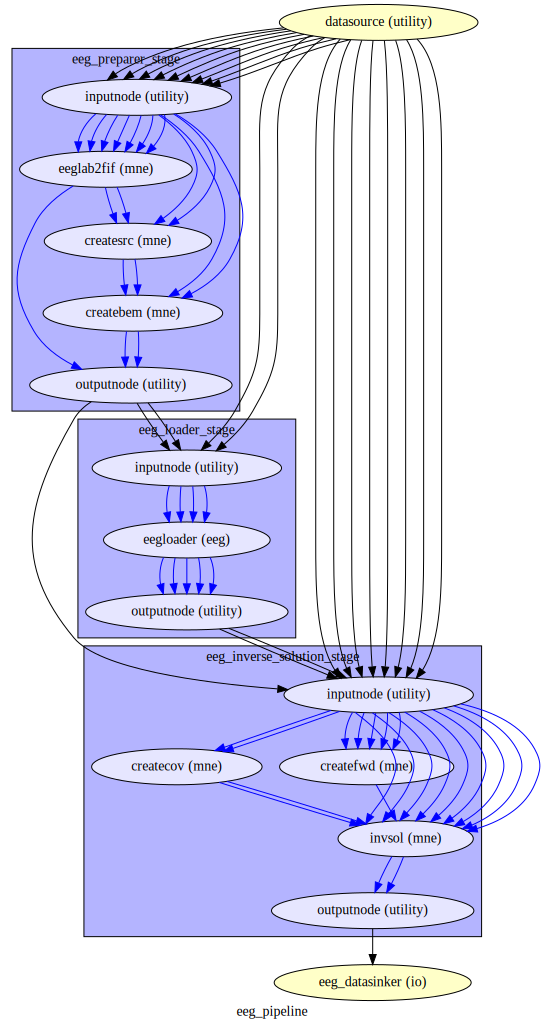

In [8]:
%matplotlib inline
path_to_svg = os.path.join(output_dir,__nipype_directory__,participant_label,'eeg_pipeline','graph.svg')
display(SVG(filename=path_to_svg))

Apart from the input ("datasource") and output ("eeg sinker") nodes that are apart, you can see three blue boxes that represent the stages of the pipeline flow:

    * Preparer stage
    * Loader stage
    * Inverse solution stage

Each of the stages, again, has an input and and output node, as well as several nodes representing processing steps. Each processing step has its own "interface" which you can find in ``cmtklib/interfaces`` ("mne" in parentheses indicates that they are defined in the file mne.py).

In the following, we will go over the interfaces and show what output they produce. 

### Preparer stage

Let's first have a look at the information given by the config file regarding this stage: 

>     "eeg_preparer_stage": {
        "eeg_format": ".set",
        "epochs": "sub-01_task-faces_desc-preproc_eeg.set",
        "invsol_format": "mne-sLORETA",
        "parcellation": {
            "label": "lausanne2008", 
            "desc": "",
            "suffix": "scale1"
        },        
        "number_of_threads": 1,
        "EEG_params": {
            "expe_name": "faces",
            "EEG_event_IDs": {
            	"SCRAMBLED" : 0,
            	"FACES" : 1 
            	},
            "start_t": -0.2, 
            "end_t" : 0.6
        }
    },


The preparer stage has three processing steps: 

- `eeglab2fif`: reads eeglab data and converts them to MNE format (.fif file extension)
- `createsrc`: creates the dipole locations along the surface of the brain 
- `createbem`: creates the boundary element method

#### eeglab2fif

If your data are not already in MNE format (`.fif` file extension), they have to be read and re-saved. The eeglab2fif interface does this for EEGLAB-format data (`.set` file extension). The interface produces a file named `sub-01_epo.fif` in the `derivatives/cmp-v3.0.3` folder. Critically, the saved epochs contain a montage, i.e. the sensor locations which have to be supplied in a file names `sub-01.xyz` inside the subject's EEGLAB derivatives folder (`derivatives/eeglab/sub-01/eeg/sub-01.xyz`). 

In [9]:
# Let's have a look at the EEG data
with warnings.catch_warnings(): # suppress some irrelevant warnings coming from mne.read_epochs_eeglab()
    warnings.simplefilter("ignore")
    epochs_eeglab = mne.read_epochs_eeglab(os.path.join(output_dir,__eeglab_directory__,\
                                participant_label,'eeg',participant_label+'_task-faces_desc-preproc_eeg.set')) # sub-01_FACES_250HZ_prepd.set

# eeglab2fif removes a baseline and crops the epochs according to parameters start_t and end_t in config file
start_t = -0.2
end_t = 0.6
epochs_eeglab.apply_baseline((start_t,0))
epochs_eeglab.crop(tmin=start_t,tmax=end_t)
evoked_eeglab = epochs_eeglab.average().pick('eeg')

# compare to what eeglab2fif saved
epochs_mne = mne.read_epochs(os.path.join(output_dir,'cmp-v3.0.3',\
                                participant_label,'eeg',participant_label+'_epo.fif'))
evoked_mne = epochs_mne.average().pick('eeg')

Extracting parameters from /home/katharina/data/VEPCON/derivatives/eeglab-v14.1.1/sub-06/eeg/sub-06_task-faces_desc-preproc_eeg.set...
Not setting metadata
Not setting metadata
596 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)
Reading /home/katharina/data/VEPCON/derivatives/cmp-v3.0.3/sub-06/eeg/sub-06_epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128)  idle
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
596 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


<Figure size 432x288 with 0 Axes>

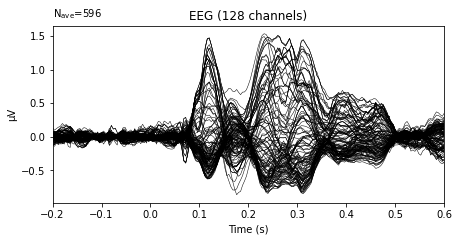

<Figure size 1080x720 with 0 Axes>

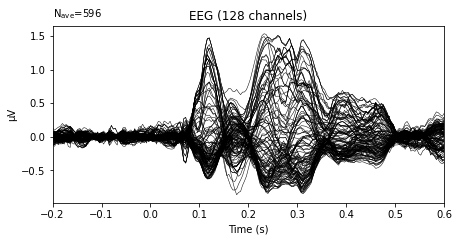

In [10]:
# plot and convince yourself it's the same
%matplotlib inline
fig = plt.figure()
plt.rcParams['figure.figsize'] = (15, 10)

_=evoked_mne.plot(time_unit='s')

fig = plt.figure()
plt.rcParams['figure.figsize'] = (15, 10)

_=evoked_eeglab.plot(time_unit='s')

#### createsrc

MNE is able to create volume- and surface-based source spaces, but in our pipeline, we use surface-based only. In order to do this, MNE takes advantage of the Freesurfer-created outputs in the `derivatives/freesurfer-7.1.1` derivatives directory. 

#### createbem

The BEM (boundary element model) is the head model we use, in our case, it is based on the individual's structural MRI and, again, related freesurfer derivatives. Its creation consists of two steps:

1. The necessary surfaces (brain, inner skull, outer skull, and outer skin) are extracted using ``mne.bem.make_watershed_bem()``. The surfaces are saved in the subject's freesurfer-directory in a new folder `bem/` watershed.

2. The model itself is created using ``mne.make_bem_model()`` and ``mne.make_bem_solution()``. In this step, the surfaces and the tissue conductivities between the surfaces are used. 

In [11]:
# Let's visualize the BEM surfaces and source space
src = mne.read_source_spaces(os.path.join(output_dir,'cmp-v3.0.3',\
                                participant_label,'eeg',participant_label+'_src.fif'))
# plot will appear in separate window
%matplotlib qt 
# lines are the surfaces, pink dots are the sources (dipoles)
_=mne.viz.plot_bem(subject=participant_label, subjects_dir=project.freesurfer_subjects_dir,
                 brain_surfaces='white', src=src, orientation='sagittal')

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Using surface: /home/katharina/data/VEPCON/derivatives/freesurfer-7.1.1/sub-06/bem/inner_skull.surf
Using surface: /home/katharina/data/VEPCON/derivatives/freesurfer-7.1.1/sub-06/bem/outer_skull.surf
Using surface: /home/katharina/data/VEPCON/derivatives/freesurfer-7.1.1/sub-06/bem/outer_skin.surf


### Loader stage

During the preparer stage, we have told CMP3 which file extensions and keywords to look for that are going to be used in the actual inverse solution. Using nipype's "BIDS datagrabber", it gathers the necessary inputs in this step. 

### Inverse solution stage

The only implemented inverse solution algorithm right now is sLORETA. 

This stage has again three processing steps: 

- `createfwd`: creates the forward solution (leadfield) from the BEM and the source space
- `createcov`: creates the noise covariance matrix from the data
- `invsol_MNE`: creates the actual inverse operator and applies it, resulting in ROI-time courses

#### createfwd

In creating the forward solution, the electrode positions need to be known. Remember, we added them to the MNE epochs during execution of `eeglab2fif`. However, in this step, it is crucial that those coordinates and the Freesurfer-surfaces used in the creation of the head model and the surface space are aligned. Any necessary transformations area passed to ``mne.make_forward_solution()`` as the "trans" argument. Since we are using non-defaced MRIs, which are not exactly the same as the ones provided on OpenNeuro, we need this transform: 

```
array([[ 1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.   ,  0.   , -0.009],
       [ 0.   ,  0.   ,  1.   ,  0.011],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])
```

The transform has to be provided as sub-01-trans.fif and can be created manually or from a text-file using mne.write_trans. Here we assume that we have this file and can load it. 

In [12]:
# Let's check the alignment between MRI and electrode positions.
trans = mne.read_trans(os.path.join(output_dir,'cmp-v3.0.3',\
                                participant_label,'eeg',participant_label+'-trans.fif'))
mne.viz.plot_alignment(epochs_mne.info, trans=trans, subject=participant_label,
                       subjects_dir=project.freesurfer_subjects_dir, dig=False,
                       surfaces=dict(head=0.95), coord_frame='mri')

Using pyvistaqt 3d backend.

Using outer_skin.surf for head surface.
Channel types::	eeg: 128


#### createcov

MNE uses an estimate of signal to noise ratio in its creation of the inverse solution. For that, it considers the pre-stimulus period of the EEG recordings.

    128 x 128 full covariance (kind = 1) found.
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
Computing rank from covariance with rank=None
    Using tolerance 1.5e-14 (2.2e-16 eps * 128 dim * 0.52  max singular value)
    Estimated rank (eeg): 127
    EEG: rank 127 computed from 128 data channels with 0 projectors


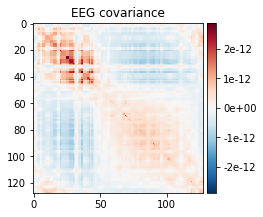

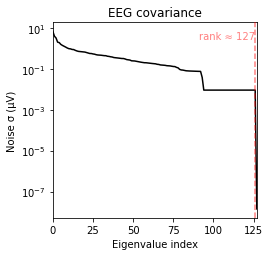

In [13]:
# Let's have a look at the noise covariance.
%matplotlib inline
noise_cov = mne.read_cov(os.path.join(output_dir,'cmp-v3.0.3',\
                                participant_label,'eeg',participant_label+'_noisecov.fif'))
fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, epochs_mne.info)

#### invsol_MNE

Now, everything comes together to create the inverse operator, which is then applied to the EEG data to create source time courses. In the last step, the source time courses are converted to ROI-time courses according to the selected parcellation. 

The outputs that are necessary for this step to work were created in the previous processing steps, namely: 

- the EEG epochs in .fif-format
- the electrode montage
- the head model
- the source point locations
- the forward operator
- the noise covariance

First, the inverse operator is created using ``mne.minimum_norm.make_inverse_operator()``. We use the options 

```
loose=1, depth=None, fixed=False
```

This means that we are obtaining full 3-dimensional dipoles whose orientation is not fixed or constrained to be (somewhat) orthogonal to surface; and we are not applying any depth weighting. The solution is written to a file `sub-01-inv.fif` in the same directory as the other outputs (`derivatives/cmp-v3.0.3/sub-01/eeg`). 

In a subsequent step in the same interface, this inverse operator is then applied to the epochs (not the evoked time course averaged over trials) using mne.minimum_norm.apply_inverse_epochs. 

The final step performed by this interface and by the EEG pipeline is to use mne.extract_label_time_course to create ROI-time courses according to ``mne.read_labels_from_annot()``. As given in the config file, we use "lausanne2008" scale 1, which is the Desikan-atlas. The time courses and the ROI-names are stored in ``sub-01_rtc_epo.pkl``, i.e. a format that is not specific to MNE.

Let's have a look at the time courses.

In [14]:
with open(os.path.join(output_dir,'cmp-v3.0.3',participant_label,'eeg',participant_label+'_rtc_epo.pkl'),'rb') as f:
    rtc_epo = pickle.load(f)
    # for some reason, MNE writes label time courses as lists. convert to numpy array
    rtc_epo['data'] = np.array(rtc_epo['data'])

In [15]:
# sort labels to make the time courses look nicer
N = len(rtc_epo['labels'])-2 # two "unknown" regions - do not plot
sorting = list(np.arange(0,N,2))+list(np.arange(1,N,2)) # left and right always alternating
# list of ROI names
labels_list_left = [i.name for i in rtc_epo['labels'][0::2] if i.name!='unknown -lh']
labels_list_right = [i.name for i in rtc_epo['labels'][1::2] if i.name!='unknown -rh']
labels_list = labels_list_left+labels_list_right

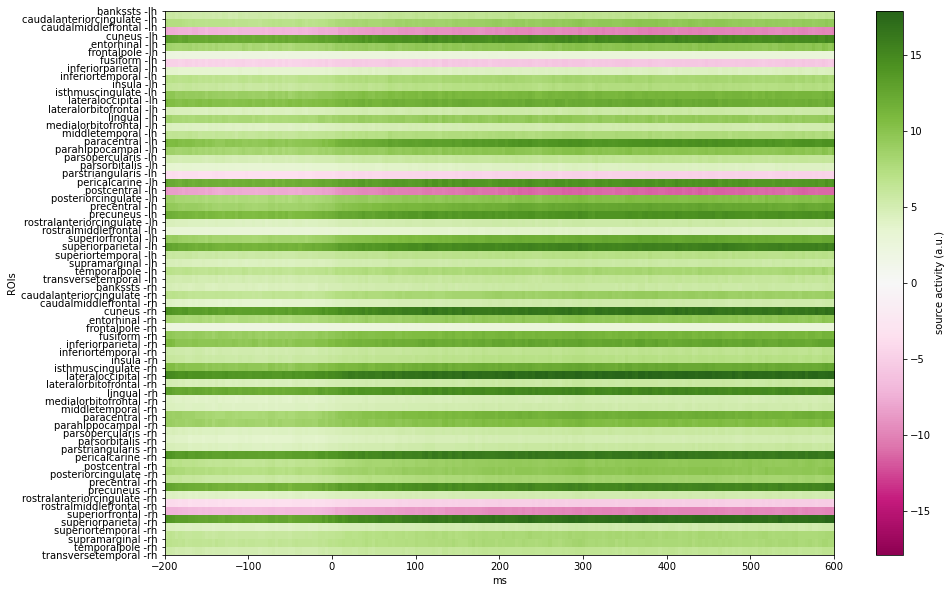

In [16]:
# plot
%matplotlib inline
to_plot = np.mean(rtc_epo['data'][:,:-2,:],axis=0)
vminmax = np.max(abs(to_plot))
plt.rcParams['figure.figsize'] = (15, 10)
plt.imshow(to_plot[sorting,:],aspect='auto',extent=[-200,600,0,67],interpolation='None',vmin=-vminmax,vmax=vminmax,cmap='PiYG');
plt.xlabel('ms')
plt.ylabel('ROIs')
cbar = plt.colorbar()
cbar.set_label('source activity (a.u.)')
locs = np.arange(0,N)
_=plt.yticks(locs,labels_list[-1::-1] )  

We can see that some of the time courses are "flipped" (have the opposite sign of the others). We will not address this problem here, but this is because of the step where dipole time courses are summarized for each brain region, using PCA. The direction of the resulting vector is not uniquely defined. 

## Connectivity measures

Of course, the idea of CMP3 is to provide connectomes! This interface is not implemented yet in the pipeline, but with the ROI-time courses, it is easy to obtain functional connectivity matrices using MNE functions. 

Keep in mind that we only plot a single subject's connectivity here, so it is not surprising if you do not see exactly what you would expect. 

In [17]:
sfreq = epochs_mne.info['sfreq']  # the sampling frequency
con_methods = ['pli', 'wpli2_debiased', 'ciplv']

label_ts = rtc_epo['data']

con = mnec.spectral_connectivity(
    label_ts, method=con_methods, mode='multitaper', sfreq=sfreq,
    faverage=True, mt_adaptive=True, n_jobs=1)

# Save the weighted connectome file according to the naming convention of CMP3
con_output_fname = os.path.join(
    output_dir,
    'cmp-v3.0.3',
    participant_label,
    'eeg',
    f'{participant_label}_atlas-L2018_res-scale1_conndata-network_connectivity.nc'
)
con.save(con_output_fname)

# con is a 3D array, get the connectivity for the first (and only) freq. band
# for each method
con_res = dict()
for method, c in zip(con_methods, con):
    con_res[method] = c.get_data(output='dense')[:, :, 0]

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2415 connections
    using t=0.000s..0.800s for estimation (201 points)
    frequencies: 6.2Hz..124.4Hz (96 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI, Debiased WPLI Square, ciPLV
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epo

In [18]:
label_names = [label.name for label in rtc_epo['labels']]

lh_labels = [name for name in label_names if name.endswith('lh')]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(rtc_epo['labels'][idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = mnec.viz.circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
# plot will appear in separate window
%matplotlib qt 
mnec.viz.plot_connectivity_circle(con_res['wpli2_debiased'], label_names, n_lines=300,
                         node_angles=node_angles, node_colors='r',
                         title='All-to-All Connectivity left-Auditory '
                               'Condition (PLI)')

(<Figure size 576x576 with 2 Axes>,
 <PolarAxesSubplot:title={'center':'All-to-All Connectivity left-Auditory Condition (PLI)'}>)

virtual void QEventDispatcherUNIX::registerSocketNotifier(QSocketNotifier*): Multiple socket notifiers for same socket 11 and type Read


This concludes the tutorial.